In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import subprocess
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import namedtuple
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')


[nltk_data] Downloading package wordnet to /kaggle/working/...


In [ ]:
path = "./train 2.csv"
df = pd.read_csv(path)
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
(df
     .groupby("class")
     .agg(
        hate_speech_count=("hate_speech_count", "mean"),
        offensive_language_count=("offensive_language_count", "mean"),
        neither_count=("neither_count", "mean"),
     )
     .round(1)
)

,hate_speech_count,offensive_language_count,neither_count
class,,,
0,2.3,0.8,0.1
1,0.2,3.0,0.1
2,0.1,0.3,2.8


In [ ]:
df = (df
    .drop(columns=["count", "hate_speech_count", "offensive_language_count", "neither_count"])
)
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
df["class"].value_counts(dropna=False, normalize=True).sort_index()

class
0    0.057701
1    0.774321
2    0.167978
Name: proportion, dtype: float64

In [ ]:
df = (df
    .assign(
        class_=df["class"].map({
            0:1,
            1:1,
            2:0
        })
    )
    .drop(columns=["class"])
    .rename(columns={"class_": "class"})
)

df["class"].value_counts(dropna=False, normalize=True).sort_index()

class
0    0.167978
1    0.832022
Name: proportion, dtype: float64

In [ ]:
class_map = {
    0: "neutral",
    1: "offensive and hate speech"
}

In [ ]:
def remove_urls(text, replacement_text=""):
    """Remove URLs from string."""
    pattern = re.compile(r"https?://\S+|www\.\S+")
    return pattern.sub(replacement_text, text)


def remove_twitter_handles(text, replacement_text=""):
    """Remove twitter handles from string."""
    pattern = re.compile(r"@[\w]+")
    return pattern.sub(replacement_text, text)


def remove_twitter_rt(text, replacement_text=""):
    """Remove twitter RTs from string."""
    pattern = re.compile(r"^RT|\s+RT\s+")
    return pattern.sub(replacement_text, text)


def remove_alphanumerics(text, replacement_text=" "):
    """Remove alphanumerics from string but leave single quote be."""
    pattern = re.compile(r"[^A-Za-z0-9']+")
    return pattern.sub(replacement_text, text)


def remove_multiple_whitespaces(text, replacement_text=" "):
    """Remove multiple whitespaces from string."""
    pattern = re.compile(r"\s{2,}")
    return pattern.sub(replacement_text, text)


def decode_html_character_references(text):
    """Decode HTML chacarters in string, e.g. &#38; and &amp;."""
    import html
    return html.unescape(text)


df = (df
    .assign(
        tweet_clean=lambda df_: (df_["tweet"]
            .apply(decode_html_character_references)
            .apply(remove_twitter_handles)
            .apply(remove_twitter_rt)
            .apply(remove_urls)
            .apply(remove_alphanumerics)
            .apply(remove_multiple_whitespaces)
            .str.strip()
        )
    )
)

df.tail()


,tweet,class,tweet_clean
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1,you's a muthaf in lie right His TL is trash No...
24779,"you've gone and broke the wrong heart baby, an...",0,you've gone and broke the wrong heart baby and...
24780,young buck wanna eat!!.. dat nigguh like I ain...,1,young buck wanna eat dat nigguh like I aint fu...
24781,youu got wild bitches tellin you lies,1,youu got wild bitches tellin you lies
24782,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...,0,Ruffled Ntac Eileen Dahlia Beautiful color com...


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
# warnings.filterwarnings('ignore')

def tokenize(doc):
    return word_tokenize(doc)


def remove_stopwords(doc):
    stops = set(stopwords.words("english"))
    stops.add("rt")
    return [token for token in doc if token not in stops]


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain\'t", "are not", phrase)
    phrase = re.sub(r"shan\'t", "shall not", phrase)
    phrase = re.sub(r"ma\'am", "maam", phrase)
    phrase = re.sub(r"y\'all", "you all", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

lemmatizer = WordNetLemmatizer()

df = (df
    .assign(
        tweet_preprocessed=lambda df_: (
            df_["tweet_clean"]
            .str.lower()
            .apply(lambda doc: [decontracted(word) for word in doc.split(" ")])
            .apply(lambda doc: [lemmatizer.lemmatize(word) for word in doc])
            .apply(lambda doc: " ".join(doc))
            .apply(word_tokenize)
            .apply(remove_stopwords)
       )
    )
)

df.sample(5)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


,tweet,class,tweet_clean,tweet_preprocessed
13131,My problem is caring about bitches &amp; noggas,1,My problem is caring about bitches noggas,"[problem, caring, bitch, noggas]"
1967,&#9733; BEST ASIAN MASSAGE ON THE Brooklyn Par...,0,BEST ASIAN MASSAGE ON THE Brooklyn Park slope ...,"[best, asian, massage, brooklyn, park, slope, ..."
86,"""@BrokenPiecesmsc: @ItsNotAdam faggot read my ...",1,faggot read my tweets after dat k it wasn't ev...,"[faggot, read, tweet, dat, k, even, funny, lol]"
14757,RT @CommonWhiteGirI: don&#8217;t send me snapc...,1,don t send me snapchats from something i wasn ...,"[send, snapchats, something, invited, rude, bi..."
5882,@dpalmyx3 @michelleb_xo both you bitches go to...,1,both you bitches go to sleep,"[bitch, go, sleep]"


In [ ]:
y = df["class"].values
x = df["tweet_preprocessed"].values
x = [(" ").join(doc) for  doc in x]

x = np.asarray(x)
y = np.asarray(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.1, random_state=8)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

22304 22304
2479 2479


In [ ]:
def return_score(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0.0)
    recall = recall_score(y_true, y_pred, average="weighted")
    matrix = confusion_matrix(y_true, y_pred, normalize="true")
    Scores = namedtuple("Scores", ["acc", "f1", "precision", "recall", "matrix"])
    return Scores(acc, f1, precision, recall, matrix)

In [ ]:
dummy = DummyClassifier()
logistic = LogisticRegression(max_iter=1_000, random_state=8)
svc = LinearSVC(max_iter=1_000, random_state=8)
sgd = SGDClassifier()
knn = KNeighborsClassifier()
bayes = MultinomialNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()


models = [
    dummy,
    logistic,
    sgd,
    dt,
    rf,
    xgb,
]

for model in models:
    model_name = model.__class__.__name__
    model_scores = []

    print(model_name)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=8)
    for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):

        print(f"\tFold {i}")

        # create train and val subset
        x_train_count = x_train[train_index]
        y_train_count = y_train[train_index]
        x_val_count = x_train[val_index]
        y_val_count = y_train[val_index]

        # oversample minority class in train set to deal with class imbalance
        # not oversample the val set to keep it untouched
        ros = RandomOverSampler(random_state=42)
        x_train_count, y_train_count = ros.fit_resample(x_train_count.reshape(-1, 1), y_train_count)
        x_train_count = x_train_count.flatten()

        if model_name != "DummyClassifier":
            # vectorize
            vectorizer = CountVectorizer()
            vectorizer.fit(x_train_count)
            x_train_count = vectorizer.transform(x_train_count)
            x_val_count = vectorizer.transform(x_val_count)

        # fit and predict
        model.fit(x_train_count, y_train_count)
        y_pred = model.predict(x_val_count)
        scores_this_fold = return_score(y_val_count, y_pred)
        model_scores.append(scores_this_fold)

    # print scores
    mean_acc = np.asarray([score.acc for score in model_scores]).mean()
    mean_f1 = np.asarray([score.f1 for score in model_scores]).mean()
    mean_precision = np.asarray([score.precision for score in model_scores]).mean()
    mean_recall = np.asarray([score.recall for score in model_scores]).mean()
    print(f"\tAcc: {mean_acc: .5f} | F1: {mean_f1: .5f} | Precision : {mean_precision: .5f} | Recall: {mean_recall: .5f}")


DummyClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.16800 | F1:  0.04833 | Precision :  0.02822 | Recall:  0.16800
LogisticRegression
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94871 | F1:  0.95039 | Precision :  0.95474 | Recall:  0.94871
SGDClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.95068 | F1:  0.95181 | Precision :  0.95421 | Recall:  0.95068
DecisionTreeClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94355 | F1:  0.94419 | Precision :  0.94515 | Recall:  0.94355
RandomForestClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94902 | F1:  0.94961 | Precision :  0.95054 | Recall:  0.94902
XGBClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94790 | F1:  0.94999 | Precision :  0.95622 | Recall:  0.94790


In [ ]:
sgd = SGDClassifier()

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample
x_train_res, y_train_res = ros.fit_resample(x_train.reshape(-1, 1), y_train)
x_train_res = x_train_res.flatten()

# Vectorize
vectorizer.fit(x_train_res)
x_train_vectorized = vectorizer.transform(x_train_res)
x_test_vectorized = vectorizer.transform(x_test)

# Fit and predict
sgd.fit(x_train_vectorized, y_train_res)
y_pred = sgd.predict(x_test_vectorized)

# Calculate scores
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print scores
print(f"Acc: {acc:.5f} | F1: {f1:.5f} | Precision: {precision:.5f} | Recall: {recall:.5f}")

Acc: 0.95200 | F1: 0.95324 | Precision: 0.95610 | Recall: 0.95200


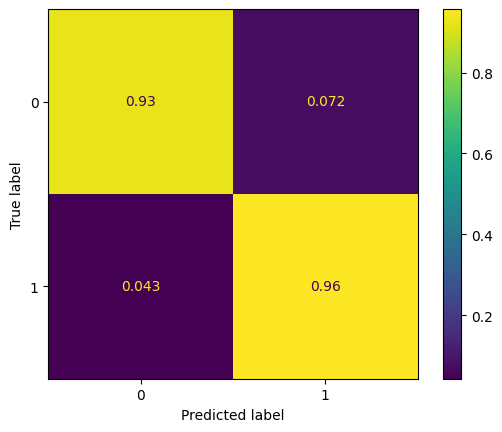

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.show()

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x, y, stratify=y, test_size=0.1, random_state=8)

X_train.shape, X_val.shape

((22304,), (2479,))

In [ ]:
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((22304, 2), (2479, 2))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')

token.fit_on_texts(X_train)

In [ ]:
max_words = 5000
token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')
token.fit_on_texts(X_train)

#Generating token embeddings
Training_seq = token.texts_to_sequences(X_train)
Training_pad = pad_sequences(Training_seq,
                             maxlen=100,
                             padding='post',
                             truncating='post')

Testing_seq = token.texts_to_sequences(X_val)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen=100,
                            padding='post',
                            truncating='post')

from keras.utils import to_categorical
train_label_one = to_categorical(Y_train, num_classes=2)
test_label_one = to_categorical(Y_val, num_classes=2)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l1()),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # Ensure the output matches the number of classes
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              run_eagerly=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 5

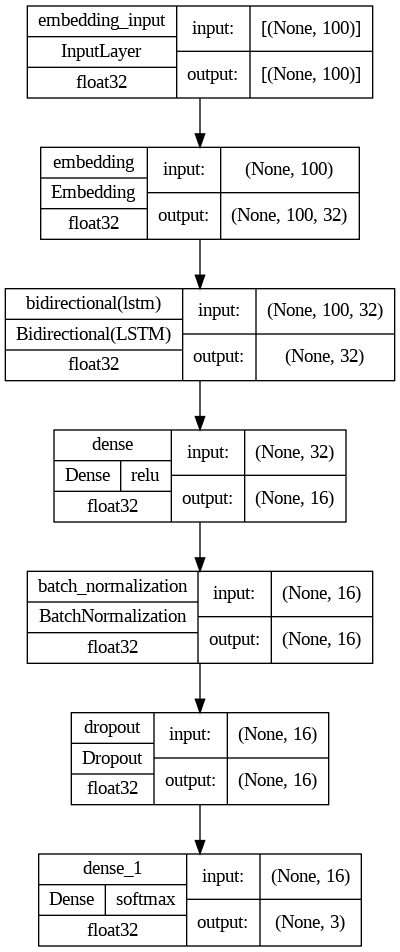

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [ ]:
Y_train_int = np.argmax(Y_train, axis=1)
Y_val_int = np.argmax(Y_val, axis=1)
history = model.fit(Training_pad, Y_train_int,
                    validation_data=(Testing_pad, Y_val_int),
                    epochs=25,
                    verbose=1,
                    batch_size=32
                    )

Epoch 1/25
697/697 [==============================] - 562s 807ms/step - loss: 0.1071 - accuracy: 0.9680 - val_loss: 0.1488 - val_accuracy: 0.9488
Epoch 2/25
697/697 [==============================] - 557s 799ms/step - loss: 0.0851 - accuracy: 0.9755 - val_loss: 0.1675 - val_accuracy: 0.9476
Epoch 3/25
697/697 [==============================] - 511s 733ms/step - loss: 0.0725 - accuracy: 0.9793 - val_loss: 0.1747 - val_accuracy: 0.9480
Epoch 4/25
697/697 [==============================] - 531s 761ms/step - loss: 0.0607 - accuracy: 0.9838 - val_loss: 0.1854 - val_accuracy: 0.9447
Epoch 5/25
697/697 [==============================] - 537s 770ms/step - loss: 0.0494 - accuracy: 0.9868 - val_loss: 0.2048 - val_accuracy: 0.9415
Epoch 6/25
697/697 [==============================] - 491s 705ms/step - loss: 0.0465 - accuracy: 0.9875 - val_loss: 0.2115 - val_accuracy: 0.9395
Epoch 7/25
697/697 [==============================] - 508s 729ms/step - loss: 0.0416 - accuracy: 0.9891 - val_loss: 0.2376 -

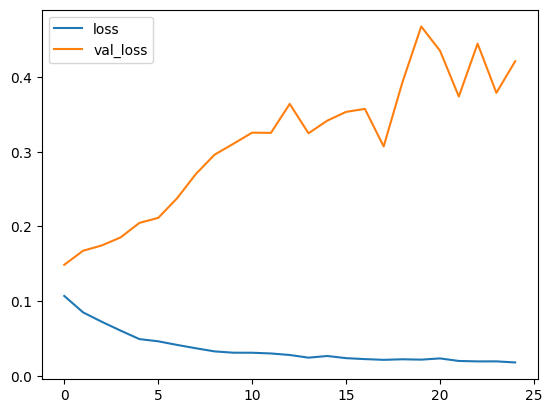

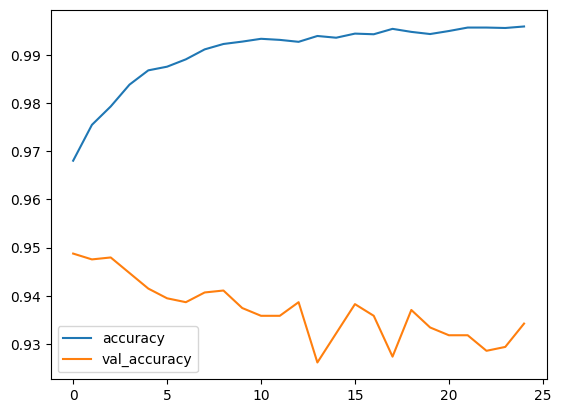

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [ ]:
y_pred = model.predict(Testing_pad)

scores = return_score(
    Y_val_int, np.argmax(y_pred, axis=1)
)
print(f"Acc: {scores.acc: .5f} | F1: {scores.f1: .5f} | Precision : {scores.precision: .5f} | Recall: {scores.recall: .5f}")

78/78 [==============================] - 24s 310ms/step
Acc:  0.93425 | F1:  0.93422 | Precision :  0.93418 | Recall:  0.93425


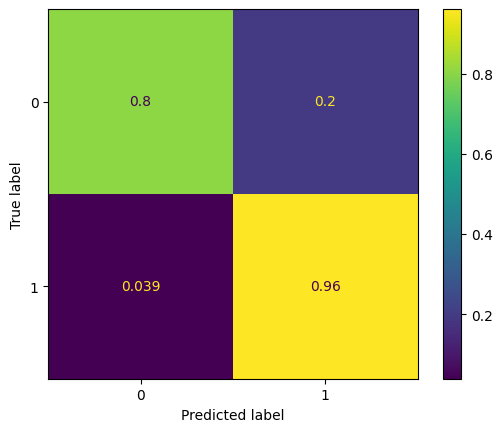

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(Y_val_int, np.argmax(y_pred, axis=1), normalize="true")
plt.show()